In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)
    
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)
    hist_off = hist_off.transpose(3,2,1,0)
    
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)
    hist_on = hist_on.transpose(3,2,1,0)
    
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
feature_names = np.array(['energy_norm_log', 'temperature_diff', 'rms_norm_log', 'details_ratedhead'])


In [4]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [5]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [6]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


# Creating Bins according to given min and max values

"Jedes der 4 Features wurde vom Minimum zum Maximum in 20 gleichmäßige bins unterteilt"

In [7]:
energy_min = summarizing_statistics['energy_norm_log_min']['off']
energy_max = summarizing_statistics['energy_norm_log_max']['off']
energy_range = energy_max - energy_min
energy_bins = np.linspace(energy_min, energy_max, num=20)

In [8]:
temp_min = summarizing_statistics['temperature_diff_min']['off']
temp_max = summarizing_statistics['temperature_diff_max']['off']
temp_range = temp_max - temp_min
temp_bins = np.linspace(temp_min, temp_max, num=20)

In [9]:
rms_min = summarizing_statistics['rms_norm_log_min']['off']
rms_max = summarizing_statistics['rms_norm_log_max']['off']
rms_range = rms_max - rms_min
rms_bins = np.linspace(rms_min, rms_max, num=20)

In [10]:
details_min = summarizing_statistics['details_ratedhead_min']['off']
#correcting manual error
details_min = 0
details_max = summarizing_statistics['details_ratedhead_max']['off']
details_range = details_max - details_min
details_bins = np.linspace(details_min, details_max, num=20)

## Splitting histogram into single features

In [11]:
hist_on.shape

(20, 20, 20, 20)

In [12]:
energy_hist = []
temp_hist = []
rms_hist = []
details_hist = []
for i in range(len(hist_on)):
    energy_total = 0
    temp_total = 0
    rms_total = 0
    details_total = 0
    for j in range(len(hist_on[i])):
        for k in range(len(hist_on[i][j])):
            for l in range(len(hist_on[i][j][k])):
                energy_total += hist_on[i][j][k][l]
                temp_total += hist_on[j][i][k][l]
                rms_total += hist_on[j][k][i][l]
                details_total += hist_on[j][k][l][i]
    energy_hist.append(energy_total)
    temp_hist.append(temp_total)
    rms_hist.append(rms_total)
    details_hist.append(details_total)

In [13]:
print('No. Observations Energy:',sum(energy_hist))
print('No. Observations Temp:',sum(temp_hist))
print('No. Observations RMS:',sum(rms_hist))
print('No. Observations Details:',sum(details_hist))

No. Observations Energy: 9639507
No. Observations Temp: 9639507
No. Observations RMS: 9639507
No. Observations Details: 9639507


## Energy

<BarContainer object of 20 artists>

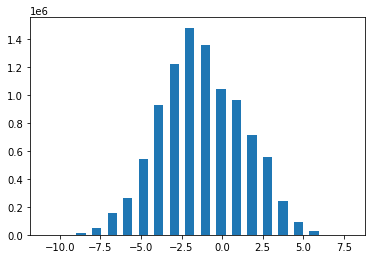

In [14]:
plt.bar(energy_bins, energy_hist, width=0.075*energy_max, bottom=None, align='center')

In [15]:
print('Reported Energy Min:', energy_min,
      '\nReported Energy Max:', energy_max,
      '\nReported Energy Mean:', summarizing_statistics['energy_norm_log_mean']['on'])

Reported Energy Min: -10.605202856980997 
Reported Energy Max: 7.588836828136981 
Reported Energy Mean: 1.8619439946941612


In [16]:
left_bins = np.linspace(energy_min, energy_max, num=21)[:-1]
print('Calculated Energy Mean (Conservative):', sum(left_bins * energy_hist)/sum(energy_hist))

Calculated Energy Mean (Conservative): -1.7167031295700792


## Temperature

<BarContainer object of 20 artists>

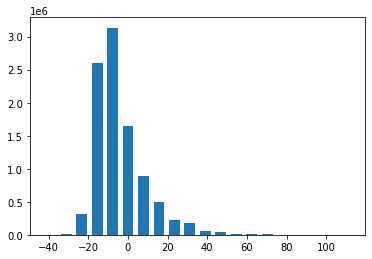

In [17]:
plt.bar(temp_bins, temp_hist, width=0.05*temp_max, bottom=None, align='center')

In [18]:
print('Reported Temperature Min:', temp_min,
      '\nReported Temperature Max:', temp_max,
      '\nReported Temperature Mean:', summarizing_statistics['temperature_diff_mean']['on'])

Reported Temperature Min: -38.875 
Reported Temperature Max: 109.14090318694541 
Reported Temperature Mean: 9.51319129294738


In [19]:
left_bins = np.linspace(temp_min, temp_max, num=21)[:-1]
print('Calculated Temperature Mean (Conservative):', sum(left_bins * temp_hist)/sum(temp_hist))

Calculated Temperature Mean (Conservative): -5.866449532579486


## RMS

<BarContainer object of 20 artists>

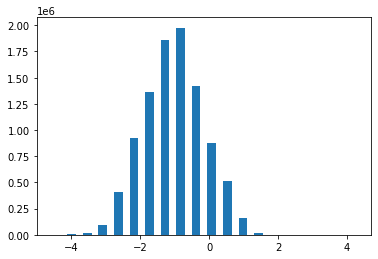

In [20]:
plt.bar(rms_bins, rms_hist, width=0.06*rms_max, bottom=None, align='center')

In [21]:
print('RMS Mean:', summarizing_statistics['rms_norm_log_mean']['on'])

RMS Mean: 0.7303305316791482


## Details

<BarContainer object of 20 artists>

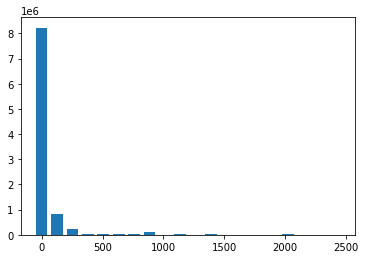

In [22]:
plt.bar(details_bins, details_hist, width=0.04*details_max, bottom=None, align='center')

In [23]:
print('Details Mean:', summarizing_statistics['details_ratedhead_mean']['on'])

Details Mean: 105.32368501044364


In [24]:
print('Min:', details_min,
      '\nMax:', details_max,
      '\nMean:', summarizing_statistics['details_ratedhead_mean']['on'])

Min: 0 
Max: 2403.0 
Mean: 105.32368501044364


In [25]:
left_bins = np.linspace(details_min, details_max, num=21)[:-1]
print('Calculated Details Mean (Conservative):', sum(left_bins * details_hist)/sum(details_hist))

Calculated Details Mean (Conservative): 52.736631717783915


# Reproducing Dataframe from Histogram

In [26]:
energy_bin_size = energy_range/19
temp_bin_size = temp_range/19
rms_bin_size = rms_range/19
details_bin_size = details_range/19

In [27]:
sample_size = 1

In [28]:
vstacked = np.empty([0, 4])
for i,_ in enumerate(tqdm(hist_on)):
    for j in range(len(hist_on[i])):
        for k in range(len(hist_on[i][j])):
            for l in range(len(hist_on[i][j][k])):
                amount = math.ceil(hist_on[i][j][k][l]*sample_size)
                if amount != 0:
                    e = np.random.uniform(low=energy_bins[i], high=energy_bins[i]+energy_bin_size, size=(amount,))
                    t = np.random.uniform(low=temp_bins[j], high=temp_bins[j]+temp_bin_size, size=(amount,))
                    r = np.random.uniform(low=rms_bins[k], high=rms_bins[k]+rms_bin_size, size=(amount,))
                    d = np.random.uniform(low=details_bins[l], high=details_bins[l]+details_bin_size, size=(amount,))
                    dstacked = np.dstack((e,t,r,d))[0]
                    vstacked = np.vstack((vstacked,dstacked))

100%|██████████| 20/20 [05:46<00:00, 17.31s/it]


In [29]:
rep_df_on = pd.DataFrame(data=vstacked, columns=['energy_norm_log','temperature_diff','rms_norm_log','details_ratedhead'])

In [30]:
rep_df_on.tail()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
9639502,8.139006,53.773296,1.741660,75.398851
9639503,7.912283,52.515524,1.838263,122.504179
9639504,8.181228,53.422337,2.107202,15.797641
9639505,8.509610,59.592661,1.309302,42.834183
9639506,8.458293,60.260682,1.624941,72.587513


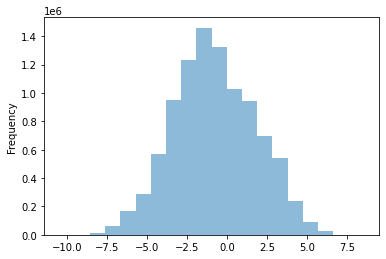

In [31]:
ax = rep_df_on['energy_norm_log'].plot.hist(bins=20, alpha=0.5)

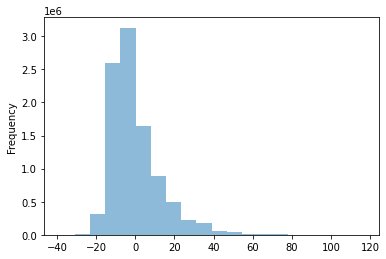

In [32]:
ax = rep_df_on['temperature_diff'].plot.hist(bins=20, alpha=0.5)

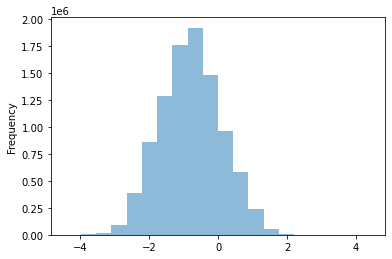

In [33]:
ax = rep_df_on['rms_norm_log'].plot.hist(bins=20, alpha=0.5)

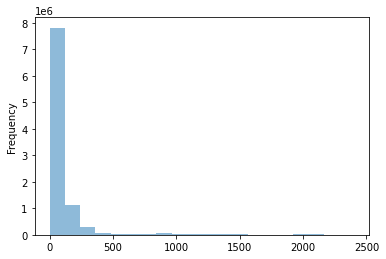

In [34]:
ax = rep_df_on['details_ratedhead'].plot.hist(bins=20, alpha=0.5)

In [35]:
replica_statistics_on =pd.DataFrame([['on_replica',
                                    len(rep_df_on),
                                    rep_df_on['energy_norm_log'].mean(),
                                    rep_df_on['temperature_diff'].mean(),
                                    rep_df_on['rms_norm_log'].mean(),
                                    rep_df_on['details_ratedhead'].mean(),
                                    rep_df_on['energy_norm_log'].min(),
                                    rep_df_on['temperature_diff'].min(),
                                    rep_df_on['rms_norm_log'].min(),
                                    rep_df_on['details_ratedhead'].min(),
                                    rep_df_on['energy_norm_log'].max(),
                                    rep_df_on['temperature_diff'].max(),
                                    rep_df_on['rms_norm_log'].max(),
                                    rep_df_on['details_ratedhead'].max(),
                                    rep_df_on.cov().values]],
                                        columns=summarizing_statistics.columns.insert(0,'label')).set_index('label')

In [63]:
all_stats_on = pd.concat([summarizing_statistics.iloc[[0]], replica_statistics_on])
all_stats_on

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off_replica,9639507,-0.770051,-0.234403,-0.793239,118.746407,-10.465764,-38.817992,-4.422738,0.000009,8.545230,116.813738,4.410749,2402.997734,"[[6.656201776604928, 2.2012765480995617, 1.760..."


In [37]:
rep_df_on.to_csv('./data/hist_on_to_df.csv', index=False)

# Load replicas and display Statistics

In [38]:
rep_df_on = pd.read_csv('./data/hist_on_to_df.csv')
rep_df_on.tail()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
9639502,8.139006,53.773296,1.741660,75.398851
9639503,7.912283,52.515524,1.838263,122.504179
9639504,8.181228,53.422337,2.107202,15.797641
9639505,8.509610,59.592661,1.309302,42.834183
9639506,8.458293,60.260682,1.624941,72.587513


In [39]:
#all_stats.to_csv('replica_summarizing_statistics.csv', index=True)

# MODEL EXPLORATION

In [40]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
random_forest_model

RandomForestClassifier(max_depth=6, min_samples_leaf=1000, min_samples_split=15,
                       n_estimators=50, random_state=10)

In [41]:
random_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1000,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

In [42]:
random_forest_model_gini_importance = random_forest_model.feature_importances_

#https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

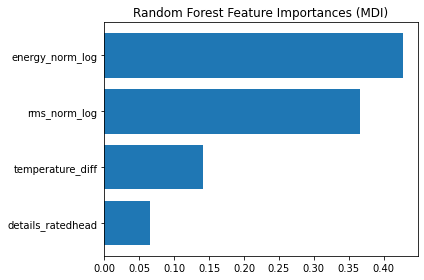

In [43]:
sorted_idx = random_forest_model_gini_importance.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, random_forest_model_gini_importance[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [44]:
np.random.randint(5)

2

# Histogram Example

In [45]:
def histogram(X, n_bins=10, mins=None, maxs=None):
    n_samples, n_features = X.shape
    if isinstance(n_bins, int):
        n_bins = [n_bins]*n_features
    n_bins = np.array(n_bins, dtype=int)
    assert n_bins.shape == (n_features,)
    if mins is None:
        mins = X.min(axis=0)
    if maxs is None:
        maxs = X.max(axis=0)
    print('mins', mins)
    print('maxs', maxs)
    
    print('(X - mins) * n_bins', (X - mins) * n_bins)
    print('(maxs - mins)', (maxs - mins))
    
    Y = np.floor((X - mins) * n_bins / (maxs - mins)).astype(int)
    print('Y', Y)
    
    print('Y[np.all(Y >= 0, axis=1)')
    Y = Y[np.all(Y >= 0, axis=1) & np.all(Y < n_bins, axis=1)] @ (np.cumprod(n_bins) // n_bins[0])
    
    
    uniques, counts = np.unique(Y, return_counts=True)  
    h = np.full(np.prod(n_bins), 0, dtype=int)
    h[uniques] = counts
    return h.reshape(n_bins)

In [46]:
example_data = pd.DataFrame(data=np.array([[np.random.randint(100) for i in range(10)],
                                 [np.random.randint(100) for i in range(10)],
                                 #[np.random.randint(100) for i in range(10)],
                                 [np.random.randint(100) for i in range(10)]]).T)

In [47]:
example_data.describe()

,0,1,2
count,10.000000,10.000000,10.000000
mean,46.600000,35.900000,39.400000
std,33.764544,32.143601,32.304798
min,2.000000,4.000000,10.000000
25%,14.500000,6.250000,12.250000
50%,50.000000,26.500000,25.500000
75%,73.000000,62.000000,69.250000
max,94.000000,87.000000,90.000000


In [48]:
example_hist = histogram(example_data.values, n_bins=3).transpose(2,1,0)

mins [ 2  4 10]
maxs [94 87 90]
(X - mins) * n_bins [[ 24   6   6]
 [276 177   9]
 [ 78 249   6]
 [174 165   0]
 [ 15   9  15]
 [243  75 213]
 [  0 213 240]
 [219   0 117]
 [195  60  78]
 [114   3 198]]
(maxs - mins) [92 83 80]
Y [[0 0 0]
 [3 2 0]
 [0 3 0]
 [1 1 0]
 [0 0 0]
 [2 0 2]
 [0 2 3]
 [2 0 1]
 [2 0 0]
 [1 0 2]]
Y[np.all(Y >= 0, axis=1)


In [49]:
example_data.head(10)

,0,1,2
0,10,6,12
1,94,63,13
2,28,87,12
3,60,59,10
4,7,7,15
5,83,29,81
6,2,75,90
7,75,4,49
8,67,24,36
9,40,5,76


In [50]:
example_data.sort_values(by=[0,1,2])

,0,1,2
6,2,75,90
4,7,7,15
0,10,6,12
2,28,87,12
9,40,5,76
3,60,59,10
8,67,24,36
7,75,4,49
5,83,29,81
1,94,63,13


In [51]:
example_data[[0]]

,0
0,10
1,94
2,28
3,60
4,7
5,83
6,2
7,75
8,67
9,40


In [52]:
np.histogram(example_data[[0]].values, 3)[1]

array([ 2.        , 32.66666667, 63.33333333, 94.        ])

In [53]:
np.histogram(example_data[[1]].values, 3)[1]

array([ 4.        , 31.66666667, 59.33333333, 87.        ])

In [54]:
np.histogram(example_data[[2]].values, 3)[1]

array([10.        , 36.66666667, 63.33333333, 90.        ])

In [55]:
example_hist

array([[[2, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 1],
        [1, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]]])

In [56]:
example_hist[0][1][1]

0

In [57]:
example_hist_np = np.histogramdd(example_data.values, bins=3)[0]

In [58]:
example_hist_np

array([[[2., 0., 0.],
        [0., 0., 0.],
        [1., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [1., 0., 0.]]])

In [59]:
example_hist_np[0][1][1]

0.0

In [60]:
example_hist.shape

(3, 3, 3)

In [61]:
example_hist_np.shape

(3, 3, 3)

In [62]:
feature_1_hist = []
feature_2_hist = []
feature_3_hist = []
feature_4_hist = []
for i in range(len(example_hist)):
    feature_1_count = 0
    feature_2_count = 0
    feature_3_count = 0
    feature_4_count = 0
    for j in range(len(example_hist[i])):
        for k in range(len(example_hist[i][j])):
            for l in range(len(example_hist[i][j][k])):
                feature_1_count += example_hist[i][j][k][l]
                feature_2_count += example_hist[j][i][k][l]
                feature_3_count += example_hist[j][k][i][l]
                feature_4_count += example_hist[j][k][l][i]
    feature_1_hist.append(feature_1_count)
    feature_2_hist.append(feature_2_count)
    feature_3_hist.append(feature_3_count)
    feature_4_hist.append(feature_4_count)

TypeError: object of type 'numpy.int64' has no len()

In [ ]:
feature_1_hist_np = []
feature_2_hist_np = []
feature_3_hist_np = []
feature_4_hist_np = []
for i in range(len(example_hist_np)):
    feature_1_count = 0
    feature_2_count = 0
    feature_3_count = 0
    feature_4_count = 0
    for j in range(len(example_hist_np[i])):
        for k in range(len(example_hist_np[i][j])):
            for l in range(len(example_hist_np[i][j][k])):
                feature_1_count += example_hist_np[i][j][k][l]
                feature_2_count += example_hist_np[j][i][k][l]
                feature_3_count += example_hist_np[j][k][i][l]
                feature_4_count += example_hist_np[j][k][l][i]
    feature_1_hist_np.append(feature_1_count)
    feature_2_hist_np.append(feature_2_count)
    feature_3_hist_np.append(feature_3_count)
    feature_4_hist_np.append(feature_4_count)

In [ ]:
example_data.head(10)

In [ ]:
example_data.describe()

In [ ]:
[(94-2)/5 * i for i in range(1,6)]

In [ ]:
feature_1_hist

In [ ]:
feature_1_hist_np

In [ ]:
example_data[[0]].plot.hist(bins=3)

In [ ]:
feature_2_hist

In [ ]:
feature_2_hist_np

In [ ]:
feature_3_hist

In [ ]:
feature_3_hist_np

In [ ]:
feature_4_hist

In [ ]:
feature_4_hist_np

# Histogram Reconstruction

In [ ]:
hist_off_new = histogram(rep_df_off.values, n_bins=20)
print(hist_off_new.shape)

In [ ]:
hist_off_new[6][5][5][5]

In [ ]:
hist_off[6][5][5][5]

In [ ]:
energy_hist_new = []
temp_hist_new = []
rms_hist_new = []
details_hist_new = []
for i in range(len(hist_off_new)):
    energy_total = 0
    temp_total = 0
    rms_total = 0
    details_total = 0
    for j in range(len(hist_off_new[i])):
        for k in range(len(hist_off_new[i][j])):
            for l in range(len(hist_off_new[i][j][k])):
                energy_total += hist_off_new[i][j][k][l]
                temp_total += hist_off_new[j][i][k][l]
                rms_total += hist_off_new[j][k][i][l]
                details_total += hist_off_new[j][k][l][i]
    energy_hist_new.append(energy_total)
    temp_hist_new.append(temp_total)
    rms_hist_new.append(rms_total)
    details_hist_new.append(details_total)

In [ ]:
print('No. Observations Energy:',sum(energy_hist_new))
print('No. Observations Temp:',sum(temp_hist_new))
print('No. Observations RMS:',sum(rms_hist_new))
print('No. Observations Details:',sum(details_hist_new))

In [ ]:
plt.bar(energy_bins, energy_hist_new, width=0.075*energy_max, bottom=None, align='center')

In [ ]:
print('Reported Energy Min:', energy_min,
      '\nReported Energy Max:', energy_max,
      '\nReported Energy Mean:', summarizing_statistics['energy_norm_log_mean']['on'])

In [ ]:
left_bins = np.linspace(energy_min, energy_max, num=21)[:-1]
print('Calculated Energy Mean (Conservative):', sum(left_bins * energy_hist_new)/sum(energy_hist_new))

In [ ]:
plt.bar(details_bins, details_hist_new, width=0.04*details_max, bottom=None, align='center')